## Create a NEXRAD Hovmoeller plot 

Uses a single azimuth from Nexrad Level 2 data file. The code left active pulls data from AWS S3 nexrad archive.
A single indicated azimuth angle is used to create an xarray Dataset. 

In [1]:
import pyart
import numpy as np
import pandas as pd
import xarray as xr
import nexrad_utils as nexu
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import s3fs
import tempfile

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### User defined variables
Start and end time, radar name, and the azimuth angle of interest.


In [2]:
ss = '01-08-2017 00Z'
ee = '01-10-2017 00Z'
icao = 'KRGX'
variable = 'reflectivity'
target_azimuth = 235

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-19 16:04:10.040062. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


### Reusuable funcions

In [3]:
def create_hov(ds, ax=None, cmap='pyart_NWSRef', vmin=-20., vmax=60., 
               range_max=250000., range_min=0., xlabel=None, ylabel=None, title=None, 
               plot_km=False, plot_grid=False, cax=None):
    if ax is None:
        plt.gca()
    if plot_km:
        rng = ds.range.values / 1000.
        xlabel = 'Range [km]'
    else:
        rng = ds.range.values
        xlabel = 'Range [m]'
    if ylabel is None:
        ylabel = 'Date-Time'
    if title is None:
        title = 'KRGX Maximum Reflectivity along the 235 deg Radial'
    refs = ds.ref.values
#    refs[refs < vmin] = np.nan
    refs = np.ma.masked_less(refs, vmin)
    
#    hovd.ref.plot.pcolormesh(ax=ax)
    date_format = mdates.DateFormatter('%Y-%m-%d %H%mZ')
    ax.yaxis.set_major_formatter(date_format)
    hovp = ax.pcolormesh(rng, ds.time.values, refs, cmap=cmap, vmin=vmin, vmax=vmax)
    hovp.cmap.set_under('w')
    ax.set_xlim(range_max, range_min)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if plot_grid:
        ax.grid(True, axis='both')
    plt.colorbar(hovp, cax=cax)
    return ax

def draw_beam_terrain_profile(ds, azimuth, ax=None, ymin=None, ymax=None, 
                              range_max=250000., range_min=0., 
                              fill_color='0.75', plot_km=False, plot_grid=False):
    '''Draw the Beam height along with terrain and PBB'''
    if ax is None:
        ax = plt.gca()
    if ymin is None:
        ymin = 0.
    if ymax is None:
        ymax = 5000.
    az_ind = np.argmin(np.abs(terrain.azimuth.values - azimuth))
        
    if plot_km:
        rng = ds.range.values / 1000.
        topo_ht = ds.topography.values[az_ind, :] / 1000.
        xlab = 'Range (km)'
        ylab = 'Height (km)'
    else:
        rng = ds.range.values
        topo_ht = ds.topography.values[az_ind, :]
        xlab = 'Range (m)'
        ylab = 'Height (m)'

    tf = ax.fill_between(rng, 0., topo_ht,  color=fill_color)
    ax.set_xlim(range_max, range_min)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if plot_grid:
        ax.grid(True, axis='both')
    return ax

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-19 16:04:12.233395. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


## Section 1 - Retrieve Data

#### Get the file list for processing, then create the composite along an azimuth

The first cell pulls data from AWS, while the second line could be modified to use local data. 

Following that is a way to work locally if desired.

Each input variable can be changed by the top cell of user defs.

These functions return an Xarray dataset, which makes creating a hovmoeller simple.

In [3]:
file_list = nexu.get_s3_list(ss, ee, icao)
hovd = nexu.get_composite_from_s3_list(file_list, icao, variable, target_azimuth)
hovd.ref.values[hovd.ref.values > 1000] = np.nan

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-11-30 19:59:05.186968. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


#### Copy files locally from S3 - For testing purposes
This could be run as a code cell if desired.

s3conn = s3fs.S3FileSystem(anon=True)
for filen in file_list:
    path, filename = os.path.split(filen)
    with s3conn.open(filen, 'rb') as temp88d:
        f = open(os.path.join('/Users/guy/software/tmp/nexhov/', filename), 'wb')
        f.write(temp88d.read())
        print("{} Copied locally".format(filename))
        f.close()

In [4]:
#file_list = glob.glob('/Users/guy/software/tmp/nexhov/data/KRGX*')
#hovd = nexu.get_composite_from_list(file_list, icao, variable, target_azimuth)

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-11-30 19:59:15.149975. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/core/transforms.py:205: RuntimeWarning: invalid value encountered in arccos
  full_angle_rad = np.arccos(dot_product)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/core/transforms.py:185: RuntimeWarning: invalid value encountered in less
  edges[edges < 0] += 360     # range from [-180, 180] to [0, 360]


Let's look at what the Dataset looks like

In [5]:
hovd

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-12-01 07:30:06.821063. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


<xarray.Dataset>
Dimensions:  (range: 1832, time: 806)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-08T00:00:35 2017-01-08T00:03:47 ...
  * range    (range) float32 2125.0 2375.0 2625.0 2875.0 3125.0 3375.0 ...
Data variables:
    ref      (time, range) float32 -14.0 -20.0 -14.0 -14.5 -13.5 -15.5 -13.0 ...

#### Now we can easily plot a hovmoeller of the processed data
Note the labels could be changed

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-12-01 08:39:10.712293. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


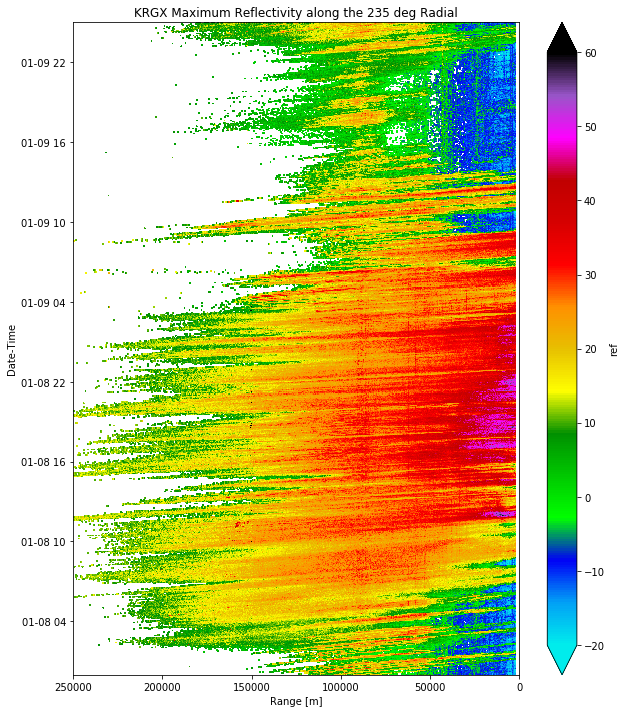

In [14]:
fig, ax = plt.subplots(figsize=(10, 12))
hovd.ref.plot.pcolormesh(ax=ax, cmap=pyart.graph.cm.NWSRef, vmin=-20., vmax=60.)
ax.set_xlim(250000, 0.)
ax.set_xlabel('Range [m]')
ax.set_ylabel('Date-Time')
ax.set_title('KRGX Maximum Reflectivity along the 235 deg Radial')

### Save data to output file

This is important if you want to avoid reprocessing the data (which isn't real fast)!

In [13]:
hovd.to_netcdf(path='20170108_10_235_radial_comp.nc')

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-12-01 07:38:43.709716. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


## Section 2 - Created plot from previously saved Data (recommended for iterations on plots)

In [4]:
hovd = xr.open_dataset('data/20170108_10_235_radial_comp.nc')
terrain = xr.open_dataset('data/KRGX_block_terrain.nc')

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-19 16:04:23.297111. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-19 16:04:24.239058. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


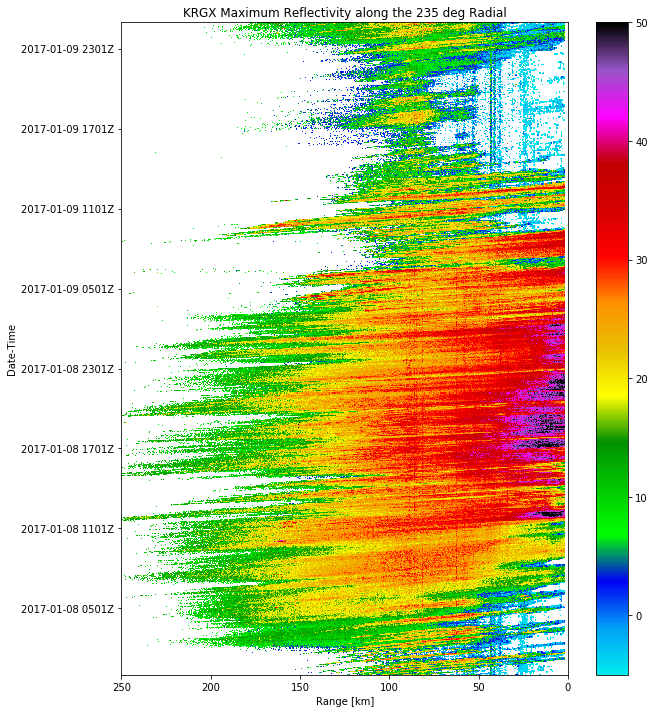

In [5]:
fig, ax = plt.subplots(figsize=(10, 12))
ax = create_hov(hovd, ax=ax, title='KRGX Maximum Reflectivity along the 235 deg Radial', 
                plot_km=True, range_max=250., range_min=0., vmin=-5., vmax=50.)


__If you want to save the image, just use the matplotlib savefig on the figure instance passed back.__


`fig.savefig(output_imagename)`

In [6]:
terrain

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-19 16:04:36.921130. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


<xarray.Dataset>
Dimensions:     (azimuth: 361, range: 601)
Coordinates:
  * azimuth     (azimuth) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * range       (range) float32 -37.2286 379.335 795.898 1212.46 1629.02 ...
Data variables:
    topography  (azimuth, range) float32 2343.41 2356.81 2362.13 2361.28 ...
    longitude   (azimuth, range) float32 -119.461 -119.461 -119.461 -119.461 ...
    latitude    (azimuth, range) float32 39.7538 39.7576 39.7613 39.7651 ...
    pbb         (azimuth, range) float32 9.96921e+36 9.96921e+36 9.96921e+36 ...
    cbb         (azimuth, range) float32 nan nan nan nan nan nan nan nan nan ...
Attributes:
    description:  PyRadarMet BeamBlockage calculations
    topo_source:  USGS GTOPO30 DEM files
    history:      Created Sat Feb 17 11:17:40 2018 using python netCDF4 module

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-19 16:09:26.455624. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


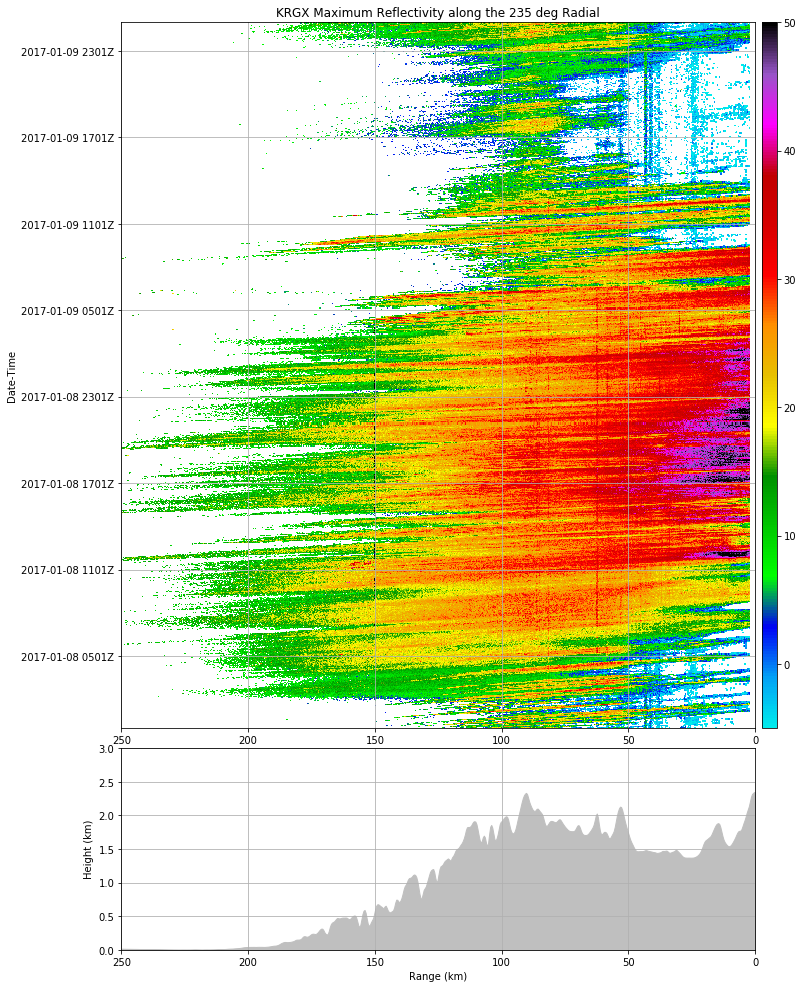

In [10]:
fig = plt.figure(figsize=(10,14))
ax1 = fig.add_axes([.05, .27, .88, .70])
cax = fig.add_axes([.94, .27, .02, .70])
ax2 = fig.add_axes([.05, .05, .88, .20])

ax1 = create_hov(hovd, ax=ax1, title='KRGX Maximum Reflectivity along the 235 deg Radial', 
                 range_max=250., range_min=0., vmin=-5., vmax=50., cax=cax,
                 plot_km=True, plot_grid=True)
#ax1.get_xaxis().set_visible(False)
ax2 = draw_beam_terrain_profile(terrain, 235, ax=ax2, ymax=3., plot_km=True, range_max=250., plot_grid=True)